## Image Forgery Detection - Fake Face (CNN)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

np.random.seed(2)

In [6]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [7]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

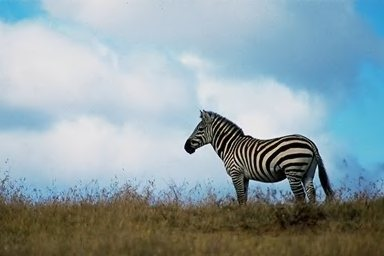

In [8]:
real_image_path = './data/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

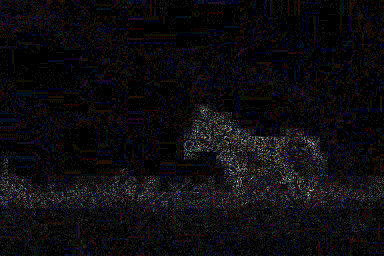

In [9]:
convert_to_ela_image(real_image_path, 90)

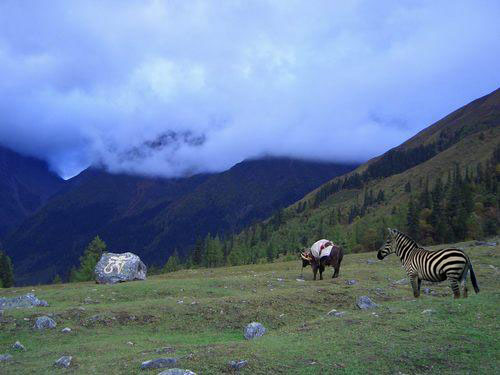

In [10]:
fake_image_path = './data/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

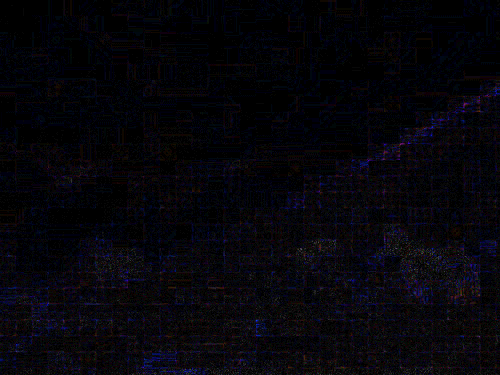

In [11]:
convert_to_ela_image(fake_image_path, 90)

In [12]:
image_size = (128, 128)

In [13]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [14]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [15]:
import random
path = './data/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [16]:
path = './data/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [17]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [19]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [20]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

2022-04-28 16:44:45.524490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 16:44:46.100044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [21]:
epochs = 30
batch_size = 32

In [22]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [24]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [25]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

2022-04-28 16:45:27.126955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-28 16:45:28.224706: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


105/105 [==============================] - 5s 19ms/step - loss: 0.5122 - accuracy: 0.7376 - val_loss: 0.3570 - val_accuracy: 0.8715
Epoch 2/30
105/105 [==============================] - 2s 15ms/step - loss: 0.3420 - accuracy: 0.8793 - val_loss: 0.3460 - val_accuracy: 0.8800
Epoch 3/30
105/105 [==============================] - 2s 15ms/step - loss: 0.3044 - accuracy: 0.9027 - val_loss: 0.2969 - val_accuracy: 0.8920
Epoch 4/30
105/105 [==============================] - 2s 15ms/step - loss: 0.2705 - accuracy: 0.9120 - val_loss: 0.2715 - val_accuracy: 0.8968
Epoch 5/30
105/105 [==============================] - 2s 15ms/step - loss: 0.2466 - accuracy: 0.9138 - val_loss: 0.2533 - val_accuracy: 0.9016
Epoch 6/30
105/105 [==============================] - 2s 15ms/step - loss: 0.2228 - accuracy: 0.9228 - val_loss: 0.2596 - val_accuracy: 0.9028
Epoch 7/30
105/105 [==============================] - 2s 15ms/step - loss: 0.2075 - accuracy: 0.9264 - val_loss: 0.2274 - val_accuracy: 0.9040
Epoch 8/30

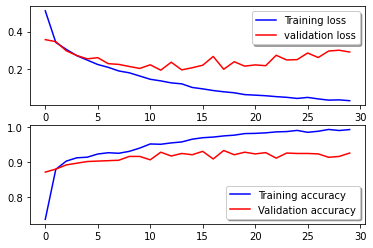

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

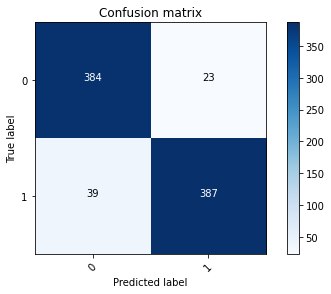

In [28]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [29]:
class_names = ['fake', 'real']

In [30]:
real_image_path = './data/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 100.00


In [31]:
fake_image_path = './data/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 99.94


In [33]:
fake_image = os.listdir('./data/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('./data/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 100.00
Class: fake Confidence: 98.06
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 98.26
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 99.98
Class: fake Confidence: 99.89
Class: fake Confidence: 99.86
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 99.76
Class: fake Confidence: 97.49
Class: fake Confidence: 96.08
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 75.90
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 99.90
Class: fake Confidence: 99.99
Class: fake Confidence: 99.47
Class: fake Confidence: 100.00
Class: fake Confidence: 100.00
Class: fake Confidence: 99.99
Class: fake Confidence: 100.00
Class: fake Confidenc

In [34]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2036, Acc: 98.64341085271317


In [35]:
real_image = os.listdir('./data/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('./data/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 91.60
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 99.92
Class: real Confidence: 99.99
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real Confidence: 96.82
Class: real Confidence: 100.00
Class: real Confidence: 100.00
Class: real 

In [36]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6970, Acc: 94.77835191732392
Total: 9418, Correct: 9006, Acc: 95.62539817370993
